In [1]:
import pandas as pd;
import numpy as  np;
from scipy.optimize import minimize;
import random;

In [3]:
ratings_small = np.genfromtxt('ratings.csv',delimiter=',',skip_header =1)[:,0:3]

In [4]:
def get_rhat(u,v):
    return np.matmul(u,np.transpose(v))

In [5]:
def cal_error(r,rhat):
    return 0.5 * np.sum(np.square(r - rhat))

In [6]:
def matrix_factorization(ratings,alpha,steps,concept=3):
    r=ratings
    row = (r.shape[0])
    col = (r.shape[1])
    
    np.random.seed(1234)
    u = np.random.rand(row,concept)
    v = np.random.rand(col,concept)
    
    e = r - get_rhat(u,v)
    e = np.array(pd.DataFrame(e).fillna(0))
    #e1 = np.zeros((row,col))
    #
    #for i in range(row):
    #    for j in range(col):
    #        if r[i][j] > 0:
    #            e1[i,j] = r[i][j] - get_rhat(u,v)[i,j]
    #           
               
    #e = r - get_rhat(u,v)
    #print(e)
    #print(e1)
    for s in range(steps):
        u_c = u + alpha * np.matmul(e,v)
        v_c = v + alpha * np.matmul(np.transpose(e),u)
       
        u = np.copy(u_c)
        v = np.copy(v_c)
        e = r - get_rhat(u,v)
        e = np.array(pd.DataFrame(e).fillna(0))
    return get_rhat(u,v)

## Dummy Test Case

In [6]:
R = [[5,3,np.nan,1],
  [4,np.nan,np.nan,1],
  [1,1,np.nan,5],
  [1,np.nan,np.nan,4],
  [np.nan,1,5,4]]
R = np.array(R)

In [7]:
matrix_factorization(R,0.002,1000)

array([[5.00479217, 2.98757696, 3.29128869, 0.99876123],
       [3.99561129, 2.12559217, 3.00200174, 0.99823669],
       [1.01425366, 0.96503099, 4.64540656, 4.997607  ],
       [0.99271356, 0.4237421 , 4.14724211, 3.99633337],
       [2.37957614, 1.04454135, 4.98434807, 4.01184795]])

## Small Dataset

In [8]:
ratings = pd.read_csv('ratings.csv')

In [9]:
r2 = ratings.pivot(index='userId', columns='movieId', values='rating');
r3 = np.asarray(r2)

In [10]:
import time

start = time.time()
matrix_factorization(r3,0.0002,1000)
end = time.time()

print('Time Taken:', end-start)

('Time Taken:', 116.64931297302246)


In [12]:
def get_indices(data):
    indice = list()
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if np.isnan(data[i][j]) == False:
                indice.append([i,j])
            else:
                pass
    return(indice)

In [13]:
indice = get_indices(r3)
print('Number of Available Data Points:', len(indice))

('Number of Available Data Points:', 100836)


In [14]:
print('Total number of possible entries in Data Matrix:', r3.shape[0]*r3.shape[1])

('Total number of possible entries in Data Matrix:', 5931640)


In [33]:
float(100836/5931640.0)

0.016999683055613623

In [36]:
print('Sparsity of Given Data Matrix: {} %'.format( (1 - (100836)/5931640.0)*100 )) 

Sparsity of Given Data Matrix: 98.3000316944 %


In [38]:
ratio = 0.1

In [37]:
def select_test(indice, ratio):
    random.seed(2018)
    test = random.sample(indice, int(ratio*len(indice)))
    return(test)

In [39]:
test = select_test(indice, 0.1)

In [41]:
len(test)

10083

In [42]:
#len(train)+len(test)

In [43]:
len(indice)

100836

In [45]:
indice[0:5]

[[0, 0], [0, 2], [0, 5], [0, 43], [0, 46]]

In [46]:
def mutate_ratings(ratings,test):
    rt = ratings.copy()
    for i in test:
        rt[i[0]][i[1]] = np.nan
    return (rt)

In [47]:
new_r3 = mutate_ratings(r3, test)

In [92]:
import time

start = time.time()

pred_new_r3_2 = matrix_factorization(new_r3,0.0002,1000, concept = 2)
pred_new_r3_3 = matrix_factorization(new_r3,0.0002,1000, concept = 3)
pred_new_r3_4 = matrix_factorization(new_r3,0.0002,1000, concept = 4)
pred_new_r3_5 = matrix_factorization(new_r3,0.0002,1000, concept = 5)

end = time.time()
print(end-start)

-0.00485684908926487


In [49]:
a = dict()
a['a'] = 7
print(a)

{'a': 7}


In [50]:
a['b']= 9
print(a)

{'a': 7, 'b': 9}


In [59]:
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse

In [60]:
def rmse_k(data, k):
    indice = get_indices(data)
    ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
    
    scores = dict()
    
    for ratio in tqdm(ratios):
        test = select_test(indice, ratio)
        new_data = mutate_ratings(data, test)
        pred = matrix_factorization(new_data,0.0002,1000, concept = k)
        y_true, y_pred = fetch_ratings(data, pred, test)
        score = mse(y_true, y_pred)
        scores[str(ratio)] = score
        
    return(scores)

In [61]:
def fetch_ratings(ratings, predicted, test):
    y_true = list()
    y_pred = list()
    for i in test:
        y_true.append(ratings[i[0]][i[1]])
        y_pred.append(predicted[i[0]][i[1]])
    return(y_true,y_pred)

In [62]:
val_2 = rmse_k(r3, k= 2)



  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [02:01<08:04, 121.04s/it]

 40%|████      | 2/5 [04:08<06:08, 122.84s/it]

 60%|██████    | 3/5 [06:10<04:05, 122.82s/it]

 80%|████████  | 4/5 [08:21<02:05, 125.16s/it]

100%|██████████| 5/5 [10:32<00:00, 126.78s/it]



In [63]:
val_3 = rmse_k(r3, k= 3)

100%|██████████| 5/5 [10:13<00:00, 122.14s/it]


In [64]:
val_4 = rmse_k(r3, k= 4)

100%|██████████| 5/5 [10:18<00:00, 123.17s/it]


In [65]:
val_5 = rmse_k(r3, k= 5)

100%|██████████| 5/5 [10:00<00:00, 120.16s/it]


In [66]:
val_6 = rmse_k(r3, k= 6)

100%|██████████| 5/5 [10:14<00:00, 122.51s/it]


In [113]:
np.save('val_2.npy', val_2) 
np.save('val_3.npy', val_3)
np.save('val_4.npy', val_4)
np.save('val_5.npy', val_5)
np.save('val_6.npy', val_6)

In [114]:
val_2 = np.load('val_2.npy').item()
val_3 = np.load('val_3.npy').item()
val_4 = np.load('val_4.npy').item()
val_5 = np.load('val_5.npy').item()
val_6 = np.load('val_6.npy').item()

In [116]:
v2 = [val_2[str(key)] for key in ratios ]
v3 = [val_3[str(key)] for key in ratios ]
v4 = [val_4[str(key)] for key in ratios ]
v5 = [val_5[str(key)] for key in ratios ]
v6 = [val_6[str(key)] for key in ratios ]

In [104]:
v2

[0.9035184299307656,
 0.907420439444916,
 0.959932134275775,
 1.0758085550575458,
 1.6232963343503812]

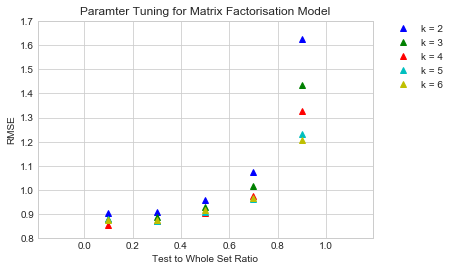

In [130]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()
plt.style.use('seaborn-whitegrid')

ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

plt.plot(ratios, v2,'b^', label='k = 2')
plt.plot(ratios, v3,'g^', label='k = 3')
plt.plot(ratios, v4,'r^', label='k = 4')
plt.plot(ratios, v5,'c^', label='k = 5')
plt.plot(ratios, v6,'y^', label='k = 6')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Paramter Tuning for Matrix Factorisation Model')
plt.xlabel('Test to Whole Set Ratio')
plt.ylabel('RMSE')
plt.axis('equal')
plt.xlim(0.1, 0.9)
plt.ylim(0.8, 1.7)
plt.show()